<font size = "5"> **Chapter 4:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss Spectra

[Download](https://raw.githubusercontent.com/pycroscopy/pyTEMlib//master/notebooks/EELS/Analysis_Core_Loss_QT.ipynb)

part of 

<font size = "5"> **[pyTEMlib](https://github.com/pycroscopy/pyTEMlib)**</font>

a 
<font size = "3"> **[pycroscopy library](https://github.com/pycroscopy)**</font>

by Gerd Duscher, 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes


## Install the newest version of sidpy
This notebook will only run with  ``version 0.0.3`` or higher.

In [4]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install git+https://github.com/pycroscopy/pyTEMlib/ -q

# pyTEMlib setup ------------------
else:
    if test_package('sidpy') < '0.0.5':
        print('installing sidpy')
        !{sys.executable} -m pip install  --upgrade sidpy -q     
    if test_package('pyNSID') < '0.0.2':
        print('installing pyNSID')
        !{sys.executable} -m pip install  --upgrade pyNSID -q 
    if test_package('pyTEMlib') < '0.2021.4.20':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


In [3]:
print(test_package('pyTEMlib'))
print(test_package('sidpy'))
print(test_package('pyNSID'))

0.2021.4.20
0.0.5
0.0.2


## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## First we import the relevant packages

In [12]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive
#                       use widget for jupyterlab needs ipympl to be installed
import sys
if 'google.colab' in sys.modules:
    import numpy as np
else:    
    %pylab --no-import-all notebook
    %gui qt

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 
import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = 'analyse_core_loss'
__notebook_version__ = '2021_02_04'

Populating the interactive namespace from numpy and matplotlib
pyTEM version:  0.2021.04.20


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


Cannot overwrite file. Using:  EELS_STO-9.hf5


C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',


<IPython.core.display.Javascript object>


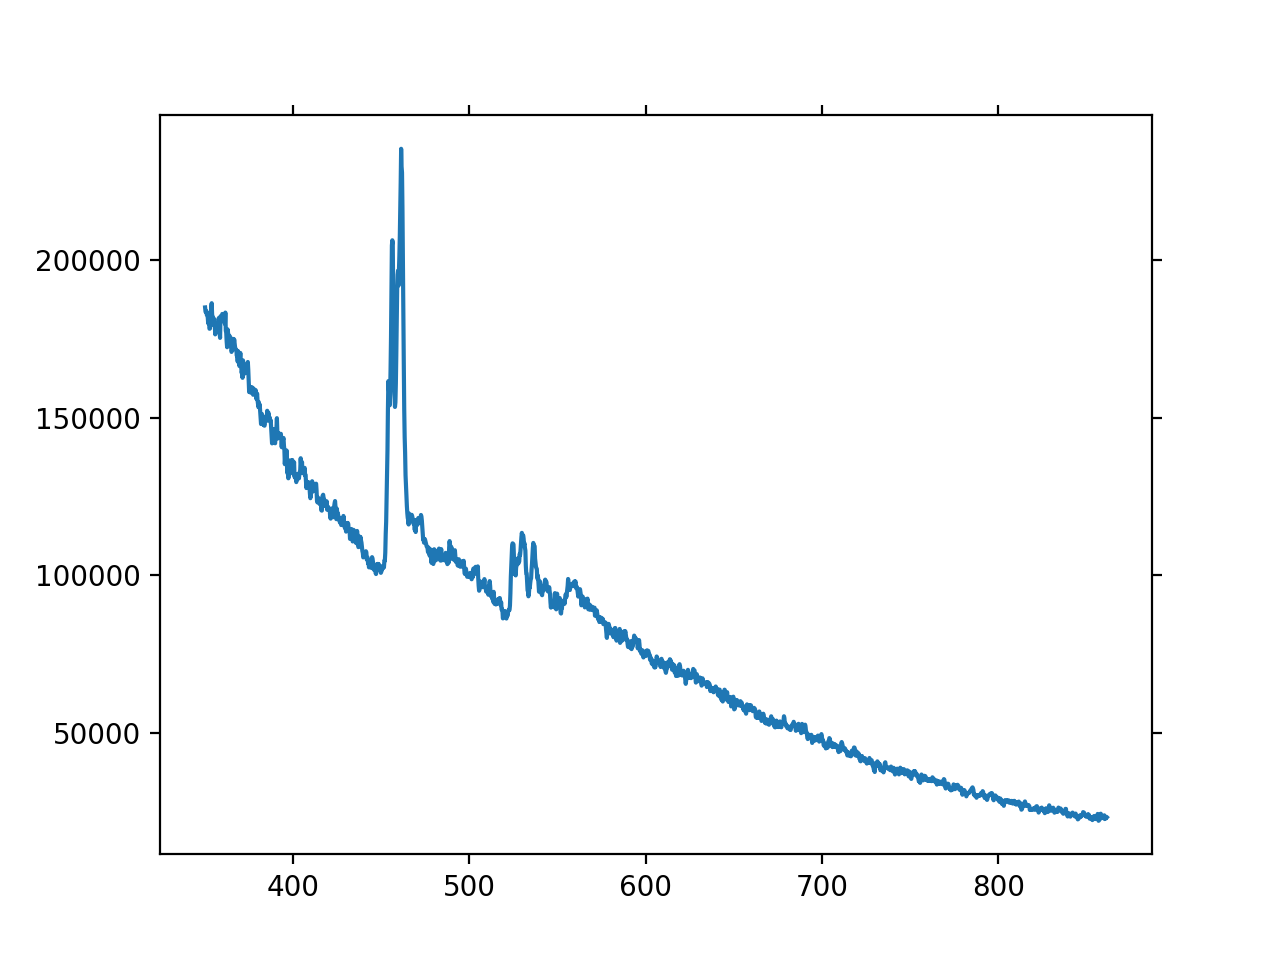

In [13]:
# -----Input -------#
load_example = True

try:
    main_dataset.h5_dataset.file.close()
except:
    pass

if load_example:
    main_dataset = ft.open_file('EELS_STO.dm3')
else:
    main_dataset = ft.open_file()

current_channel = main_dataset.h5_dataset.parent

if 'experiment' not in main_dataset.metadata:
    main_dataset.metadata['experiment']= eels.read_dm3_eels_info(main_dataset.original_metadata)

eels.set_previous_quantification(main_dataset)

# US 200 does not set acceleration voltage correctly.
# comment out next line  for other microscopes
# current_dataset.metadata['experiment']['acceleration_voltage'] = 200000

info = ieels.InfoDialog(main_dataset)

## Chemical Composition of EELS Spectra
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

<IPython.core.display.Javascript object>


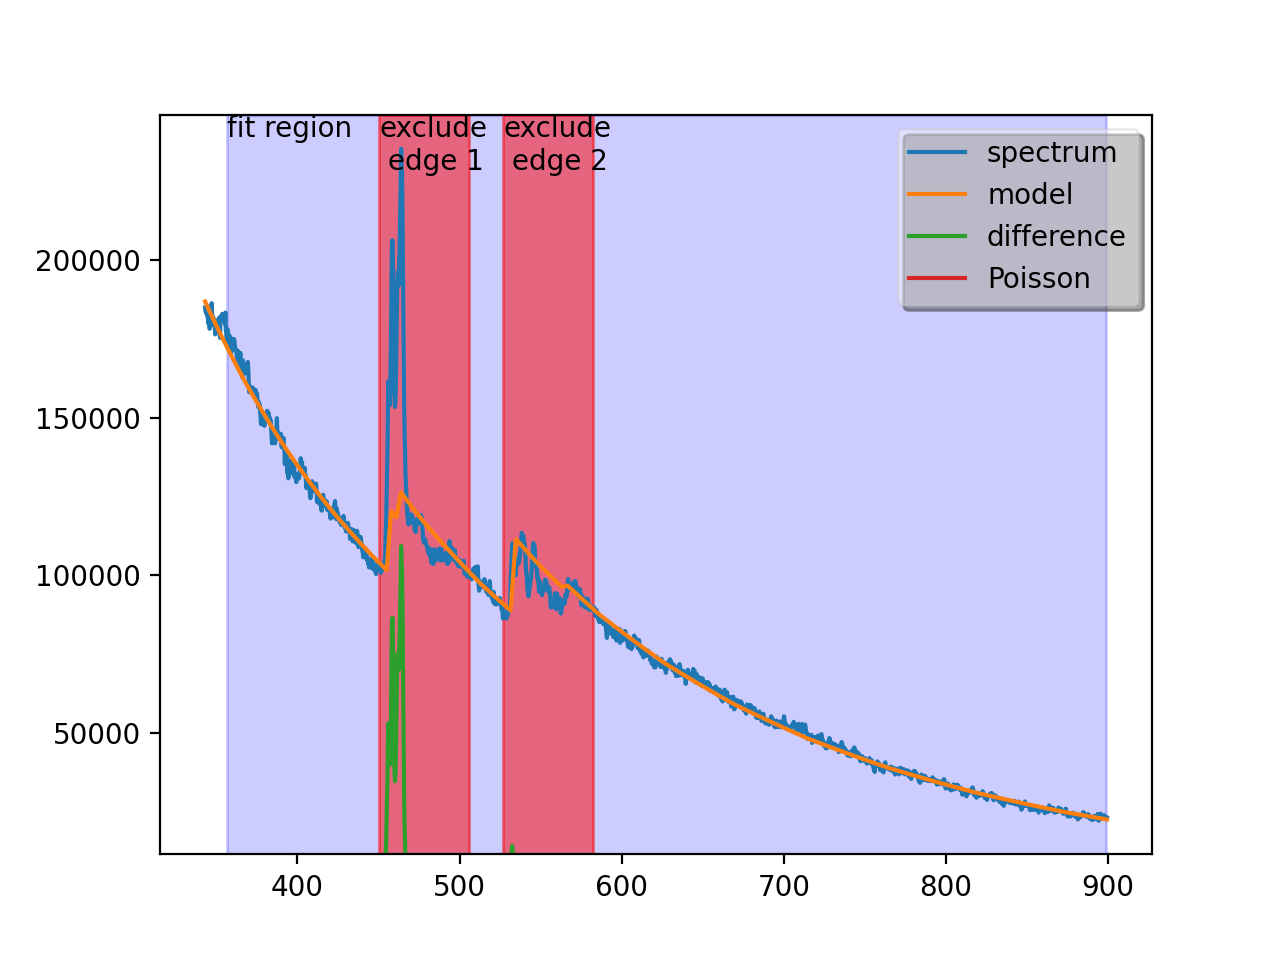

In [7]:
composition = ieels.CompositionDialog(main_dataset)

### Output of Results

In [15]:
edges = main_dataset.metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])
        
print('Relative chemical composition of ', main_dataset.title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges


Relative chemical composition of  EELS_STO
Ti: 21.8 %
O: 78.2 %


### Log Data
We write all the data to the hdf5 file associated with our dataset.

In our case that is only the ``metadata``, in which we stored the ``experimental parameters`` and the ``fitting parameters and result``.

In [16]:
current_group = main_dataset.h5_dataset.parent.parent
if 'Log_000' in current_group:
    del current_group['Log_000']

log_group = current_group.create_group('Log_000')
log_group['analysis'] = 'EELS_quantification'
log_group['EELS_quantification'] = ''
flat_dict = ft.flatten_dict(main_dataset.metadata)
if  'peak_fit-peak_out_list' in flat_dict: 
    del flat_dict['peak_fit-peak_out_list']
for key, item in flat_dict.items():
    if not key == 'peak_fit-peak_out_list':
        log_group.attrs[key]= item
current_group.file.flush()
ft.h5_tree(main_dataset.h5_dataset.file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ EELS_STO
      --------
      ├ EELS_STO
      ├ __dict__
        --------
      ├ _axes
        -----
      ├ _original_metadata
        ------------------
      ├ energy_loss
      ├ original_metadata
        -----------------
    ├ Log_000
      -------
      ├ EELS_quantification
      ├ analysis


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (2 iterations are ususally sufficient) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).


<IPython.core.display.Javascript object>


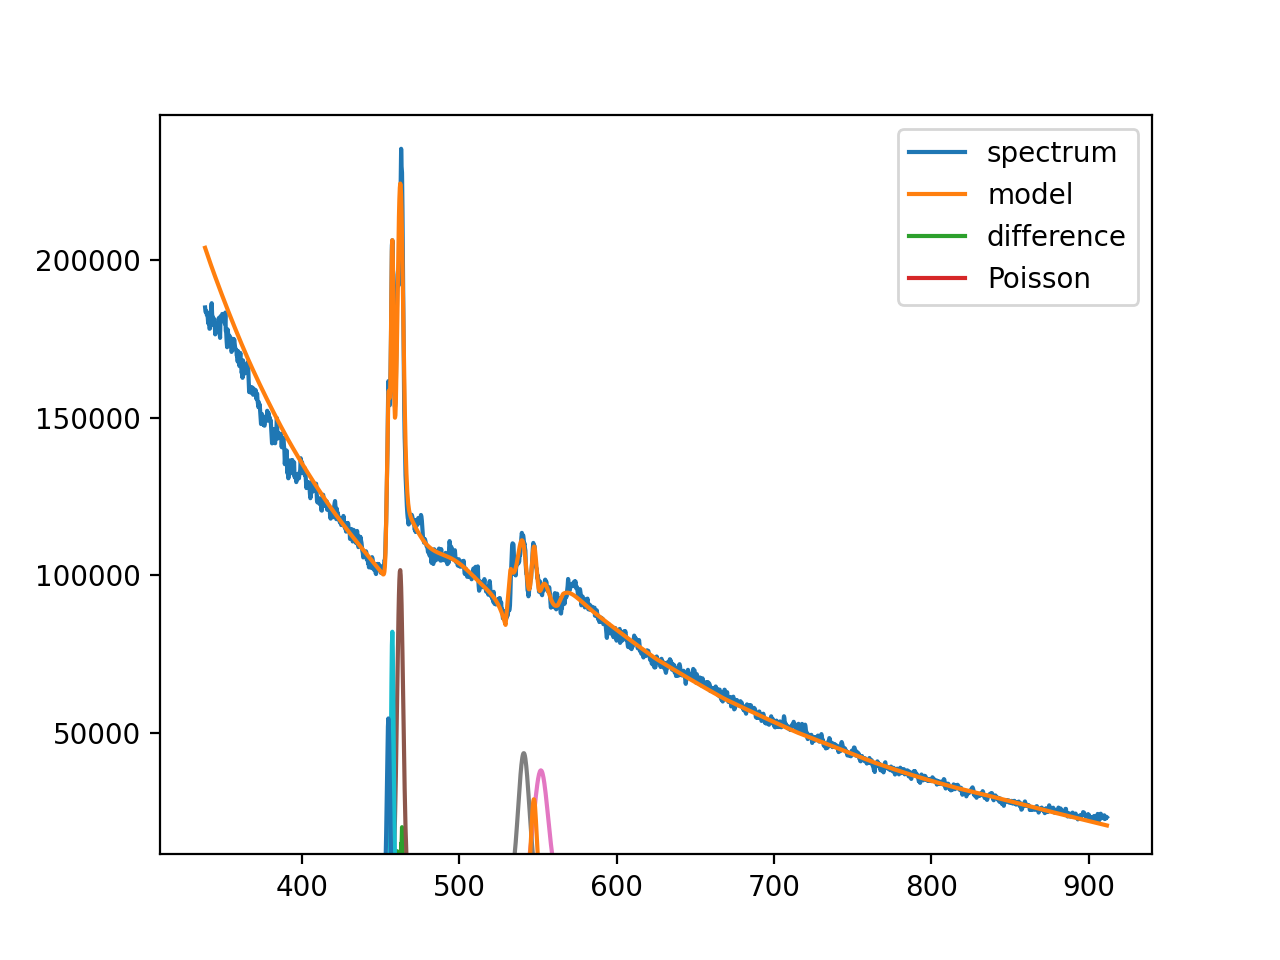

In [17]:
peak_dialog = ieels.PeakFitDialog(main_dataset)

### Output

In [20]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

peak  0: position:   546.5, area: -1706928.753 associated edge: O-K1
peak  1: position:   462.5, area:   966695.717 associated edge: Ti-L2
peak  2: position:   552.4, area:   535927.633 associated edge: O-K1
peak  3: position:   540.8, area:   534524.570 associated edge: O-K1
peak  4: position:   478.7, area:  -510933.240 associated edge: Ti-L2
peak  5: position:   457.5, area:   336775.285 associated edge: Ti-L3
peak  6: position:   455.0, area:   261505.862 associated edge: Ti-L3
peak  7: position:   547.5, area:   236244.246 associated edge: O-K1
peak  8: position:   796.5, area:  -198271.630 associated edge: 


### Log Data

In [10]:
current_group = main_dataset.h5_dataset.parent.parent
if 'Log_001' in current_group:
    del current_group['Log_001']
    
log_group = current_group.create_group('Log_001')
log_group['analysis'] = 'ELNES_fit'
log_group['ELNES_fit'] = ''
metadata = ft.flatten_dict(main_dataset.metadata)

if  'peak_fit-peak_out_list' in flat_dict: 
    del flat_dict['peak_fit-peak_out_list']
for key, item in metadata.items():
    if not key == 'peak_fit-peak_out_list':
        log_group.attrs[key]= item
current_group.file.flush()

print('Logged Data of ', main_dataset.title)
for key in current_group:
    if 'Log_' in key:
        if 'analysis' in current_group[key]:
            print(f" {key}: {current_group[key]['analysis'][()]}")

Logged Data of  1EELS Acquire (high_loss)
 Log_000: b'EELS_quantification'
 Log_001: b'ELNES_fit'


## Close File
File needs to be closed to be used with other notebooks

In [11]:
main_dataset.h5_dataset.file.close()

## Navigation
